In [1]:
import pandas as pd
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from lib.iux001 import fetch_data, aggregation_data
from lib.aux001 import calc_expression
from lib.cux001 import FactorEvaluate1

In [3]:
method = 'cicso0'
instruments = 'ics'
period = 15
task_id = '200037'
datasets = ['train', 'val']

In [4]:
total_data = fetch_data(method=method,
                        instruments=instruments,
                        task_id=task_id,
                        datasets=datasets)

./records/cicso0/ics/level2/train_data.feather
./records/cicso0/ics/level2/val_data.feather
./records/cicso0/ics/returns/train_returns.feather
./records/cicso0/ics/returns/val_returns.feather


In [5]:
total_data.head()

,trade_time,symbol,open,high,low,close,volume,money,twap,pct_change,...,realized_volatility,code,nxt1_ret_1h,nxt1_ret_2h,nxt1_ret_3h,nxt1_ret_5h,nxt1_ret_10h,nxt1_ret_15h,time_weight,equal_weight
0,2022-07-25 09:31:00,IC2208,6247.6,6249.8,6239.4,6244.0,1239,1.547158e+09,6243.571667,-0.000576,...,0.001706,IC,0.000023,0.000002,0.001130,0.002487,0.001324,0.000760,0.000201,0.000385
1,2022-07-25 09:32:00,IC2208,6243.6,6258.4,6242.2,6249.6,1032,1.290133e+09,6250.725000,0.000961,...,0.001700,IC,-0.000020,0.001107,0.002063,0.002297,0.001243,-0.000381,0.000703,0.001050
2,2022-07-25 09:33:00,IC2208,6247.4,6255.4,6245.0,6251.4,729,9.113665e+08,6250.851667,0.000640,...,0.001847,IC,0.001127,0.002083,0.002485,0.002905,0.000622,-0.000002,0.001672,0.001898
3,2022-07-25 09:34:00,IC2208,6251.8,6255.4,6244.6,6250.0,593,7.413244e+08,6250.492437,-0.000288,...,0.001404,IC,0.000956,0.001358,0.001190,0.002578,-0.000435,-0.002847,0.001129,0.001168
4,2022-07-25 09:35:00,IC2208,6251.0,6264.4,6251.0,6261.8,514,6.432987e+08,6257.268333,0.001728,...,0.001233,IC,0.000402,0.000234,0.000822,0.000973,-0.001496,-0.003941,0.000416,0.000486


In [6]:
total_data.filter(regex="^nxt1").columns.to_list()
nxt1_columns = total_data.filter(regex="^nxt1").columns.to_list()
basic_columns = [
        'close', 'high', 'low', 'open', 'volume'
        #, 'value', 'openint'
    ]

regex_pattern = r'^[^_]+_(5|10|15)_.*'
not_columns = total_data.columns[total_data.columns.str.contains(
        regex_pattern)]

factor_columns = [
        col for col in total_data.columns
        if col not in ['trade_time', 'code'] + nxt1_columns + basic_columns +
        not_columns.tolist()
    ]#[0:100]

In [7]:
#total_data

In [8]:
total_data = total_data[['trade_time', 'code'] + factor_columns + basic_columns + ["nxt1_ret_{}h".format(period)]]
total_data.head()

,trade_time,code,symbol,money,twap,pct_change,pct_change_close,pct_change_set,tick_in,tick_out,...,ask_bid_press,realized_volatility,time_weight,equal_weight,close,high,low,open,volume,nxt1_ret_15h
0,2022-07-25 09:31:00,IC,IC2208,1.547158e+09,6243.571667,-0.000576,-0.000128,0.001733,74,46.0,...,-0.069771,0.001706,0.000201,0.000385,6244.0,6249.8,6239.4,6247.6,1239,0.000760
1,2022-07-25 09:32:00,IC,IC2208,1.290133e+09,6250.725000,0.000961,0.000769,0.002631,61,59.0,...,-0.133658,0.001700,0.000703,0.001050,6249.6,6258.4,6242.2,6243.6,1032,-0.000381
2,2022-07-25 09:33:00,IC,IC2208,9.113665e+08,6250.851667,0.000640,0.001057,0.002920,67,53.0,...,0.229154,0.001847,0.001672,0.001898,6251.4,6255.4,6245.0,6247.4,729,-0.000002
3,2022-07-25 09:34:00,IC,IC2208,7.413244e+08,6250.492437,-0.000288,0.000833,0.002695,56,63.0,...,-0.145701,0.001404,0.001129,0.001168,6250.0,6255.4,6244.6,6251.8,593,-0.002847
4,2022-07-25 09:35:00,IC,IC2208,6.432987e+08,6257.268333,0.001728,0.002722,0.004588,56,64.0,...,-0.059562,0.001233,0.000416,0.000486,6261.8,6264.4,6251.0,6251.0,514,-0.003941


In [9]:
expression = "DELTA(60,MRSquared(120,'price_imbalance_3','smart_tick_in'))"

In [10]:
%%time
factor_data = calc_expression(expression=expression,
                              total_data=total_data.set_index('trade_time'))

CPU times: user 4.73 s, sys: 219 ms, total: 4.95 s
Wall time: 4.95 s


In [11]:
factor_data.head()

,trade_time,transformed,code
0,2022-07-25 09:32:00,NaN,IC
1,2022-07-25 09:33:00,NaN,IC
2,2022-07-25 09:34:00,NaN,IC
3,2022-07-25 09:35:00,NaN,IC
4,2022-07-25 09:36:00,NaN,IC


In [12]:
dt = aggregation_data(factor_data=factor_data,
                      returns_data=total_data,
                      period=period)

In [13]:
dt.tail()

,trade_time,transformed,code,nxt1_ret_15h
137516,2024-12-03 15:00:00,-0.188286,IC,-0.002082
137531,2024-12-04 09:45:00,-0.071941,IC,-0.001558
137546,2024-12-04 10:00:00,-0.039858,IC,0.000571
137561,2024-12-04 10:15:00,0.016075,IC,-0.001805
137576,2024-12-04 10:30:00,0.047577,IC,0.001900


In [14]:
evaluate1 = FactorEvaluate1(factor_data=dt,
                                factor_name='transformed',
                                ret_name='nxt1_ret_{0}h'.format(period),
                                roll_win=15,
                                fee=0.000,
                                scale_method='roll_zscore',
                                expression=expression)

In [15]:
stats_dt = evaluate1.run()

In [16]:
stats_dt

{'total_ret': 0.3447495751196594,
 'avg_ret': 3.3192690334187685e-05,
 'max_dd': -0.060887302241949603,
 'calmar': 5.662093120002562,
 'sharpe1': 0.025712542275150938,
 'sharpe2': 1.5410471257922018,
 'turnover': 0.1566455103312576,
 'win_rate': 0.5117801047120419,
 'profit_ratio': 1.1079174019457838,
 'ic_mean': 0.06600251484473871,
 'ic_std': 0.2547482648044278,
 'ic_ir': 0.2590891635529268,
 'factor_autocorr': 0.8450805346867827,
 'ret_autocorr': -0.013374547806110356}

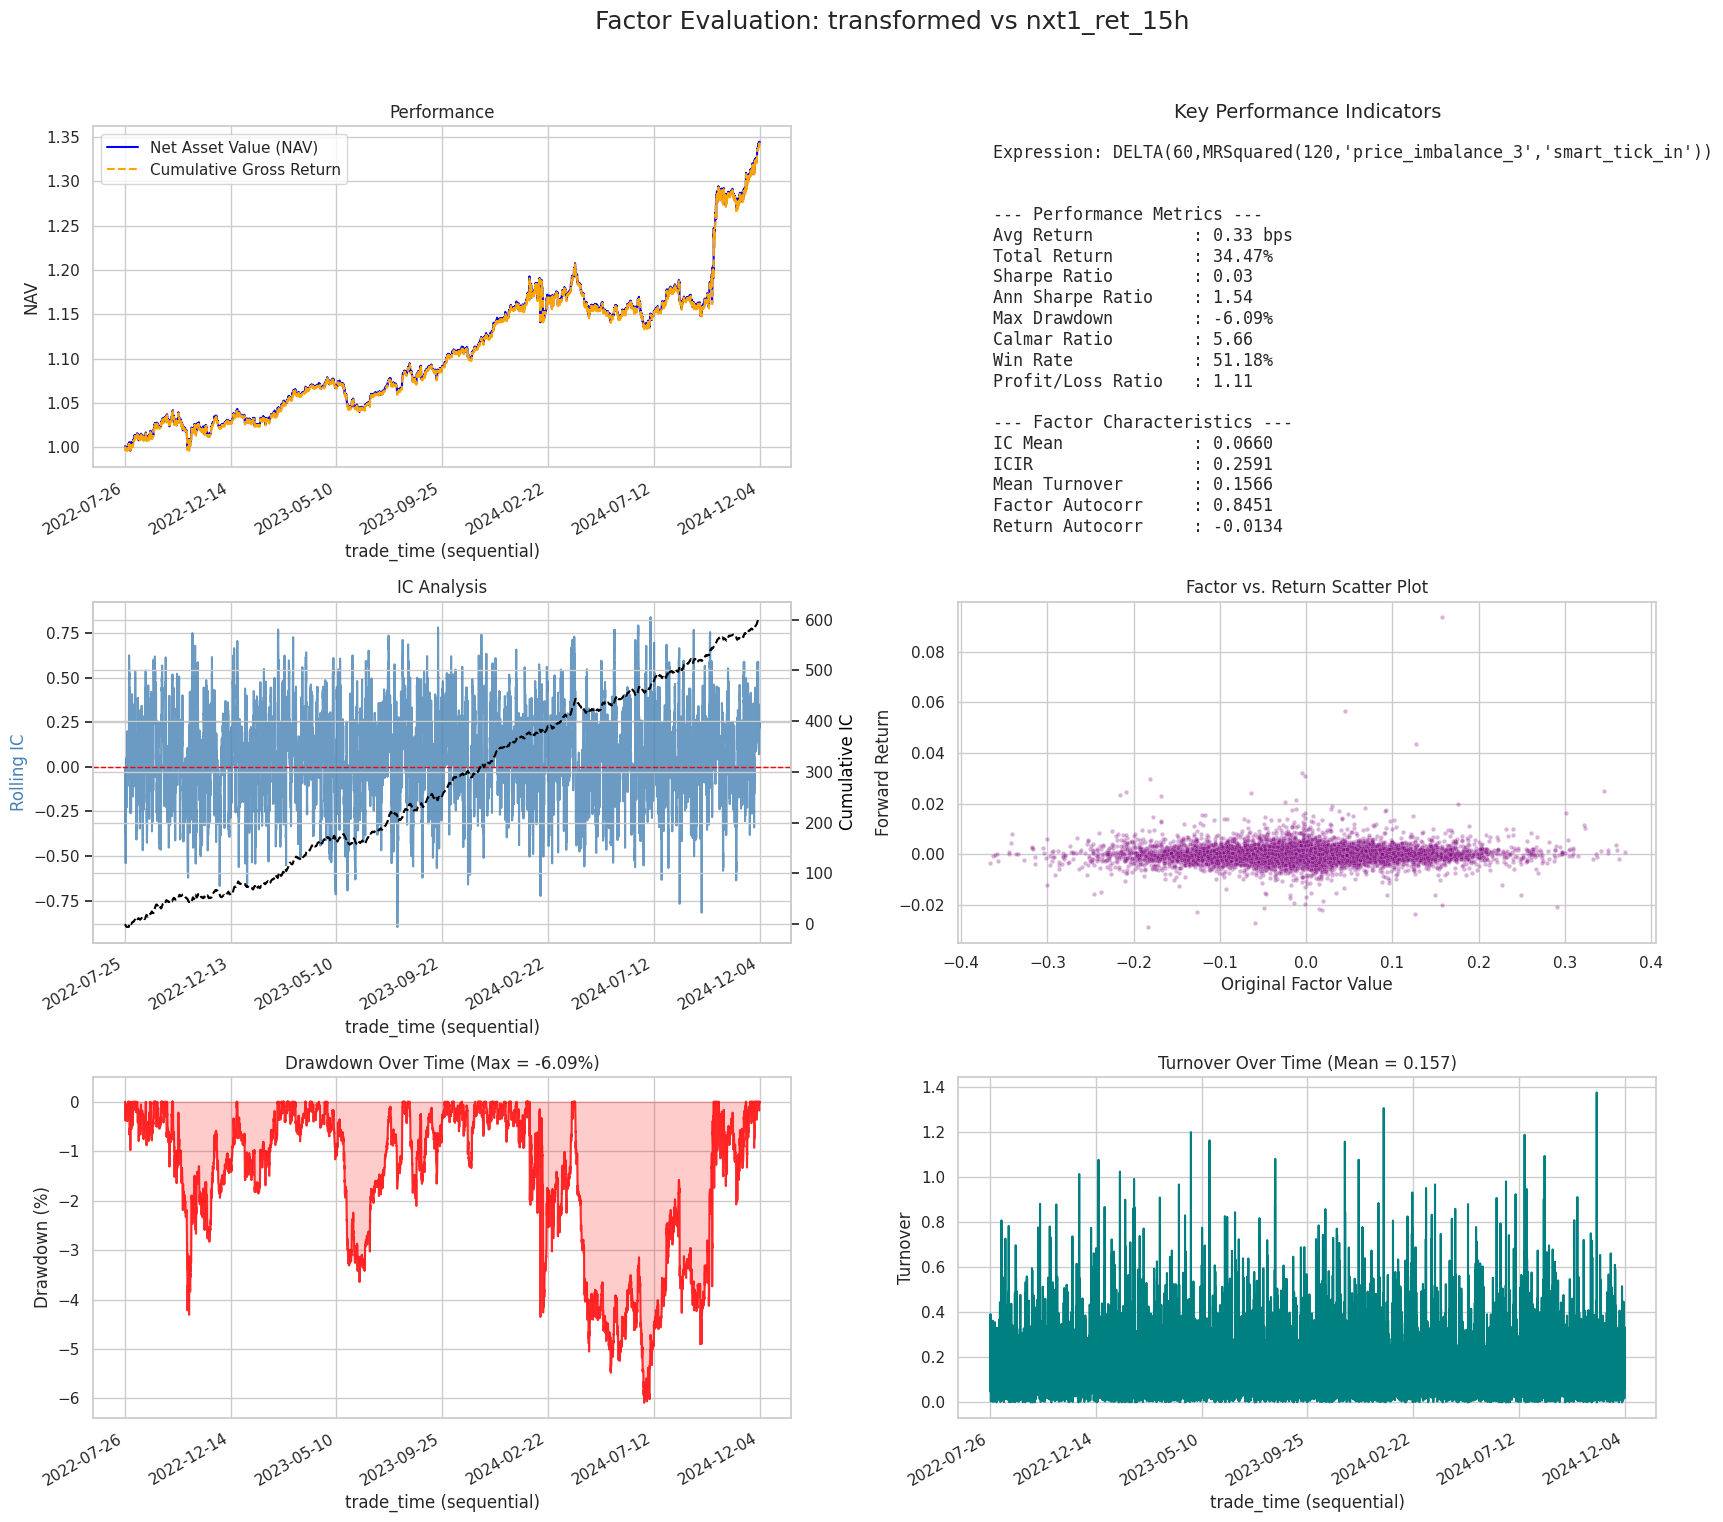

In [17]:
evaluate1.plot_results()

In [18]:
evaluate1.save_results(base_output_dir='./')

Saving results to: ./20251102_074903
Performance summary saved to: ./20251102_074903/performance_summary.txt
Saving time series data as separate files...
 -> Saved ./20251102_074903/nav.csv
 -> Saved ./20251102_074903/ic.csv
 -> Saved ./20251102_074903/turnover.csv
Evaluation plot saved to: ./20251102_074903/evaluation_plot.png
Evaluation plot also saved to: ./plot/20251102_074903.png
